In [23]:
from read_ggp_run import *
from cells_simulation import *
from matplotlib.lines import Line2D
from ipynb.fs.defs.plot_predictions import *


In [3]:
params_config = {'mean_lambda': 'bound',
                    'gamma_lambda': 'bound',
                    'var_lambda': 'bound',
                    'mean_q': 'bound',
                    'gamma_q': 'bound',
                    'var_q':'bound',
                    'beta':'bound',
                    'var_x':'bound',
                    'var_g':'bound',
                    'var_dx':'bound',
                    'var_dg':'free'} 


In [40]:
def param_estimate_noise_levels(directory, sample, param_range, 
                                exclude_param = ["var_dg", "var_dx", "var_g"],
                                labels= ["1.", "2.", "3."],
                                colors = ["cornflowerblue", "mediumblue", "darkblue"], 
                                max_xspan = 0.1):

    ### COLLECT ###
    params_reldev = dict.fromkeys(params_config.keys(), [])
    for i, p in enumerate(param_range.flatten()):
    # for i in [0]:
        for parameter in params_reldev.keys():
            directory_i = directory.format(i)
            sample_i = sample.format(i)
            filebase = default_filebase(directory_i, sample_i) # default

            _, minimization_final_file = get_minimization_file(filebase, params_config)
            params_final = read_params_config(minimization_final_file)

            init = get_params_config(params_final, parameter)["init"].values[0]
            final = get_params_config(params_final, parameter)["final"].values[0]
            reldev = (final-init)/init
            # reldev = final
            params_reldev[parameter] = params_reldev[parameter] + [reldev]

    for parameter in params_reldev.keys():
        params_reldev[parameter]  = np.reshape(params_reldev[parameter], np.shape(param_range))    

    ### PLOT ###
    fig, ax = plt.subplots(figsize=(17, 5))
    xticks = [param for i, param in  enumerate(params_reldev.keys()) if param not in exclude_param]
    subticks = np.linspace(-max_xspan, max_xspan, np.shape(param_range)[0])
    

    for j, xlabel in enumerate(xticks):
        x = np.transpose(j + np.array([subticks]*np.shape(param_range)[1]))
        # print(xlabel, x, params_reldev[xlabel])
        for col in np.arange(np.shape(param_range)[0]):
            ax.scatter(x[col], params_reldev[xlabel][col], c=colors[col])

    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks, rotation=45)

    legend_elements = [Line2D([0],[0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) \
                        for l,c in zip(labels, colors)]

    ax.axhline(0, color='grey', ls='--')
    ax.legend(handles=legend_elements)
    ax.set_ylim([-0.7, 0.])
    ax.set_title(r"relative deviation $ (\Theta_{inferred} -\Theta_{true} )/ \Theta_{true} $")
    plt.show()

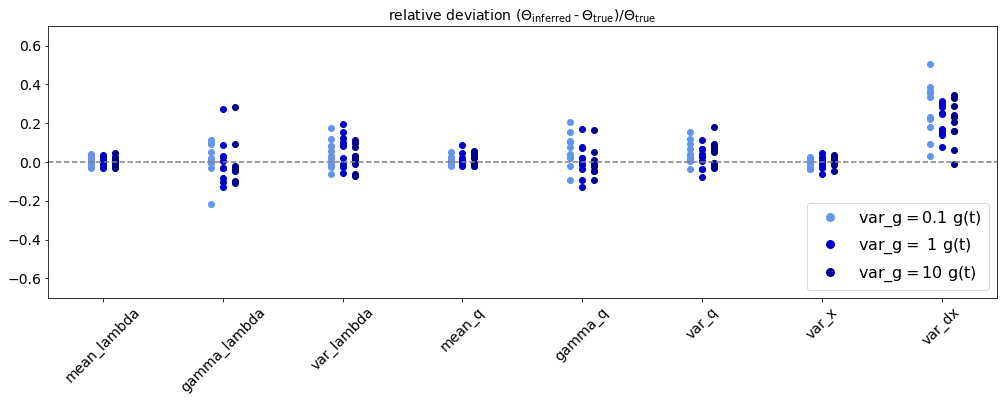

In [43]:
labels = [r'var_g$=0.1\ g(t)$', r'var_g$=\ 1\ g(t)$', r'var_g$=10\ g(t)$']

directory = '../data/scaled_noise_set_n250_var_g_sizer/'
sample = 'scaled_noise_set_n250_var_g_sizer_{:d}'
directory+=sample

param_range = np.transpose([np.geomspace(0.1, 10, 3) for i in range(10)])
param_estimate_noise_levels(directory, sample, param_range, 
                                exclude_param = ["var_dg", "beta", "var_g"],
                                labels= labels)
                                

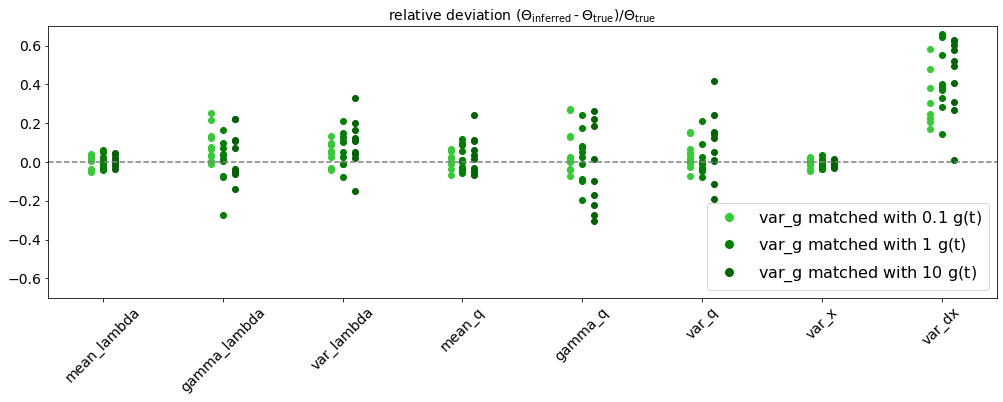

In [44]:
labels = [r'var_g matched with $ 0.1\ g(t)$', r'var_g matched with $ 1\ g(t)$', r'var_g matched with $ 10\ g(t)$']

directory = '../data/match_scaled_noise250_var_g_sizer/'
sample = 'match_scaled_noise250_var_g_sizer_{:d}'
directory+=sample

param_range = np.transpose([[363.76655668, 3674.76841188, 35993.84777024] for i in range(10)])
param_estimate_noise_levels(directory, sample, param_range, 
                                exclude_param = ["var_dg", "beta", "var_g"],
                                labels= labels, 
                                colors=["limegreen", "green", "darkgreen"])
                                

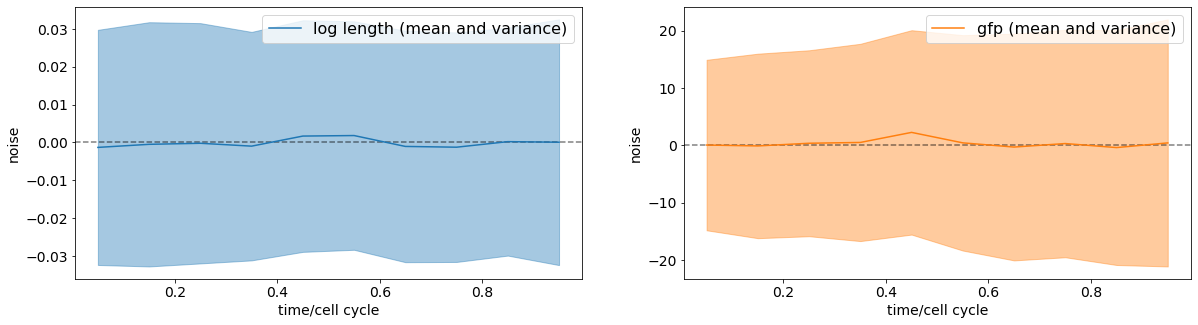

In [34]:
def plot_binned_noise(ax, time, dev, title, color, bins=10):
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(time, dev,  statistic='mean', bins=bins)
    bin_std, _, _ = scipy.stats.binned_statistic(time, dev,  statistic='std', bins=bins)
    bin_centers = bin_edges[1:] - (bin_edges[1] - bin_edges[0])/2

    ax.axhline(0, ls='--', color="black", alpha=0.5)
    ax.plot(bin_centers, bin_means, color=color, label=title+" (mean and variance)")
    bin_var = bin_std
    ax.fill_between(bin_centers, bin_means - bin_var, bin_means + bin_var, color=color, alpha=0.4)

    ax.set_ylabel("noise")
    ax.set_xlabel("time/cell cycle")
    ax.legend()

def binned_noise_level(cells_noise, cells_true, bins=10):
    time = []
    log_length_dev = []
    gfp_dev = [] 

    for i, c in enumerate(cells_true):
        time += list(cell_cycle_time(cells_noise[i]).time)
        log_length_dev  += list(np.array(cells_noise[i].log_length) - np.array(cells_true[i].log_length))
        gfp_dev         += list(np.array(cells_noise[i].gfp) - np.array(cells_true[i].gfp))

    _, ax = plt.subplots(1,2, figsize=(20,5))

    plot_binned_noise(ax[0], time, log_length_dev, "log length", "tab:blue", bins=bins)
    plot_binned_noise(ax[1], time, gfp_dev, "gfp", "tab:orange", bins=bins)
    plt.show()


i =0
directory = '../data/scaled_noise_set_n250_var_g_sizer/'
sample = 'scaled_noise_set_n250_var_g_sizer_{:d}'.format(i)
directory+=sample

filebase = default_filebase(directory, sample) # default

dat_file = get_data_file(directory, sample)
prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

indata = pd.read_csv(dat_file)
prediction = pd.read_csv(prediction_file, skiprows=13)

cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
cells_noise = df2cells(prediction, time="time", log_length="log_length", gfp="fp", parent_id=None)
cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
binned_noise_level(cells_noise, cells_true, bins=10)

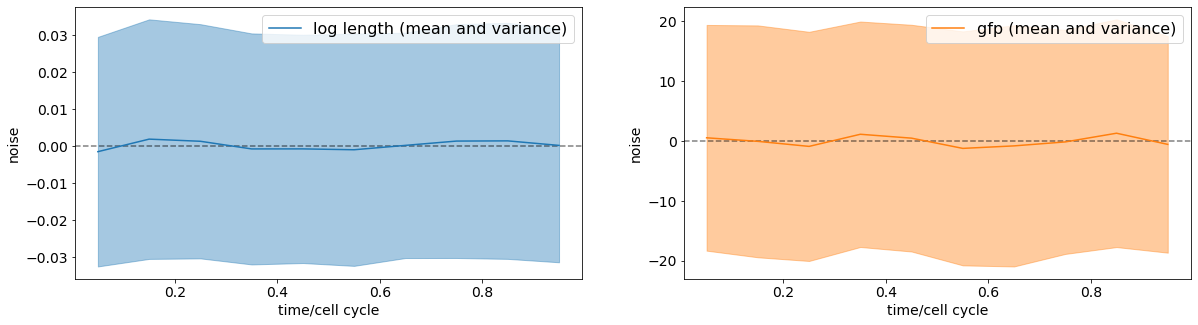

In [36]:
i =0
directory = '../data/match_scaled_noise250_var_g_sizer/'
sample = 'match_scaled_noise250_var_g_sizer_{:d}'.format(0)
directory+=sample

filebase = default_filebase(directory, sample) # default

dat_file = get_data_file(directory, sample)
prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

indata = pd.read_csv(dat_file)
prediction = pd.read_csv(prediction_file, skiprows=13)

cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
cells_noise = df2cells(prediction, time="time", log_length="log_length", gfp="fp", parent_id=None)
cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
binned_noise_level(cells_noise, cells_true, bins=10)

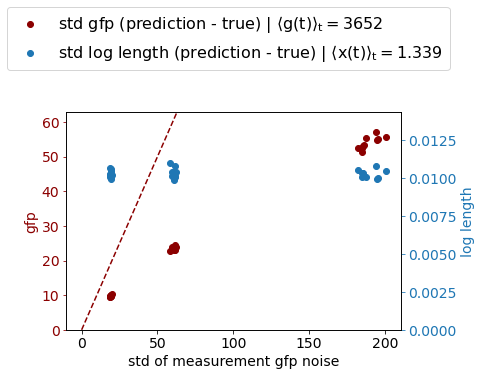

In [14]:

directory = '../data/scaled_noise_set_n250_var_g_sizer/'
sample = 'scaled_noise_set_n250_var_g_sizer_{:d}'
directory+=sample

var_gs = plot_var_predictions(directory, sample, no=30)


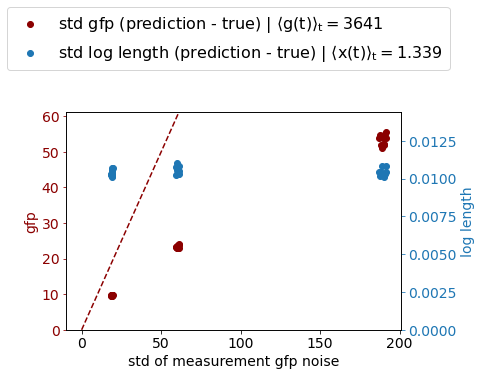

In [15]:
directory = '../data/match_scaled_noise250_var_g_sizer/'
sample = 'match_scaled_noise250_var_g_sizer_{:d}'
directory+=sample
var_gs = plot_var_predictions(directory, sample, no=30)
